# **ATLAS/ICESat-2 Land Ice Height Changes ATL11 Exploratory Data Analysis**

Adapted from https://github.com/suzanne64/ATL11/blob/master/intro_to_ATL11.ipynb

In [ ]:
import dataclasses
import os
import glob

import deepicedrain

import dask
import dask.array
import datashader
import holoviews as hv
import holoviews.operation
import hvplot.dask
import hvplot.pandas
import hvplot.xarray

# import intake
import geopandas as gpd
import numpy as np
import pandas as pd
import pygmt
import pyproj
import shapely
import tqdm
import xarray as xr
import zarr

In [2]:
client = dask.distributed.Client(n_workers=64, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:34953 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 201.22 GB


# Load Data from Zarr

Let's start by getting our data and running some preprocessing steps:
- Load 1385 (reference ground tracks) ATL11/*.zarr files
- Convert coordinates from longitude/latitude to x/y
- Convert GPS delta_time to UTC time
- Mask out low quality height (h_corr) data

In [3]:
stores = glob.glob(pathname="ATL11.001z123/ATL11_*.zarr")
print(f"{len(stores)} reference ground track Zarr stores")

1385 reference ground track Zarr stores


In [4]:
# Load dataset from all Zarr stores
# Aligning chunks spatially along cycle_number (i.e. time)
ds: xr.Dataset = xr.open_mfdataset(
    paths=stores,
    chunks={"cycle_number": 6},
    engine="zarr",
    combine="nested",
    concat_dim="ref_pt",
    parallel="True",
    backend_kwargs={"consolidated": True},
)
# ds = ds.unify_chunks().compute()
# TODO use intake
# source = intake.open_ndzarr(url="ATL11.001z123/ATL11_0*.zarr")

## Convert geographic lon/lat to x/y

To center our plot on the South Pole,
we'll reproject the original longitude/latitude coordinates
to the Antarctic Polar Stereographic (EPSG:3031) projection.

In [5]:
ds["x"], ds["y"] = deepicedrain.lonlat_to_xy(
    longitude=ds.longitude, latitude=ds.latitude
)

In [7]:
# Also set x, y as coordinates in xarray.Dataset
ds = ds.set_coords(names=["x", "y"])
# ds = ds.set_index(x="x", y="y")

## Convert delta_time to utc_time

To get more human-readable datetimes,
we'll convert the delta_time attribute from the original GPS time format
(nanoseconds since the beginning of ICESat-2 starting epoch)
to Coordinated Universal Time (UTC).
The reference date for the ICESat-2 Epoch is 2018 January 1st according to
https://github.com/SmithB/pointCollection/blob/master/is2_calendar.py#L11-L15

TODO: Account for [leap seconds](https://en.wikipedia.org/wiki/Leap_second)
in the future.

In [8]:
ds["utc_time"] = deepicedrain.deltatime_to_utctime(dataarray=ds.delta_time)

## Mask out low quality height data

Good quality data has value 0, not so good is 1-8.
Look at the 'quality_summary_ref_surf' attribute in `ds`
for more information on what the quality flags mean.

We'll mask out values other than 0 with NaN using xarray's
[where](http://xarray.pydata.org/en/v0.15.1/indexing.html#masking-with-where).

In [10]:
ds["h_corr"] = ds.h_corr.where(cond=ds.quality_summary_ref_surf == 0)

## Subset to geographic region of interest (optional)

Take a geographical subset and save to a NetCDF/Zarr format for distribution.

In [11]:
# Dictionary of Antarctic bounding box locations with EPSG:3031 coordinates
regions = {
    "kamb": deepicedrain.Region(
        name="Kamb Ice Stream",
        xmin=-739741.7702261859,
        xmax=-411054.19240523444,
        ymin=-699564.516934089,
        ymax=-365489.6822096751,
    ),
    "antarctica": deepicedrain.Region(
        "Antarctica", -2700000, 2800000, -2200000, 2300000
    ),
    "siple_coast": deepicedrain.Region(
        "Siple Coast", -1000000, 250000, -1000000, -100000
    ),
    "kamb2": deepicedrain.Region("Kamb Ice Stream", -500000, -400000, -600000, -500000),
    "whillans": deepicedrain.Region(
        "Whillans Ice Stream", -350000, -100000, -700000, -450000
    ),
}

In [12]:
# Do the actual computation to find data points within region of interest
placename: str = "kamb"  # Select Kamb Ice Stream region
region: deepicedrain.Region = regions[placename]
ds_subset: xr.Dataset = region.subset(ds=ds)
ds_subset = ds_subset.unify_chunks()
ds_subset = ds_subset.compute()

In [17]:
# Save to Zarr/NetCDF formats for distribution
ds_subset.to_zarr(
    store=f"ATLXI/ds_subset_{placename}.zarr", mode="w", consolidated=True,
)
ds_subset.to_netcdf(
    path=f"ATLXI/ds_subset_{placename}.nc", engine="h5netcdf",
)

In [18]:
# Look at Cycle Number 6 only for plotting
points_subset = hv.Points(
    data=ds_subset.sel(cycle_number=6)[[*essential_columns]],
    label="Cycle_6",
    kdims=["x", "y"],
    vdims=["utc_time", "h_corr", "cycle_number"],
    datatype=["xarray"],
)
df_subset = points_subset.dframe()

In [ ]:
# Plot our subset of points on an interactive map
df_subset.hvplot.points(
    title=f"Elevation (metres) at Cycle {cycle_number}",
    x="x",
    y="y",
    c="h_corr",
    cmap="Blues",
    rasterize=True,
    hover=True,
)

# Pivot into a pandas/dask dataframe

To make data analysis and plotting easier,
let's flatten our n-dimensional `xarray.Dataset`
to a 2-dimensiontal `pandas.DataFrame` table format.

There are currently 6 cycles (as of March 2020),
and by selecting just one cycle at a time,
we can see what the height (`h_corr`)
of the ice is like at that time.

## Looking at ICESat-2 Cycle 6

In [ ]:
cycle_number: int = 6
# Subset to essential columns
essential_columns = [
    "x",
    "y",
    "utc_time",
    "h_corr",
    "longitude",
    "latitude",
    "delta_time",
    "cycle_number",
]
dss = ds.sel(cycle_number=cycle_number)[[*essential_columns]]
dss

In [13]:
points = hv.Points(
    data=dss,
    label=f"Cycle_{cycle_number}",
    kdims=["x", "y"],
    vdims=["utc_time", "h_corr", "cycle_number"],
    datatype=["xarray"],
)

In [14]:
df = points.dframe()  # convert to pandas.DataFrame, slow
df = df.dropna()  # drop empty rows
print(len(df))
df.head()

39721113


,x,y,utc_time,h_corr,cycle_number
98215,875866.803217,-2.191334e+06,2020-02-01 18:03:28.174083225,-52.742803,6
98216,875851.241069,-2.191275e+06,2020-02-01 18:03:28.178659812,-52.848337,6
98217,875836.625343,-2.191217e+06,2020-02-01 18:03:28.186106972,-52.702757,6
98218,875822.042305,-2.191158e+06,2020-02-01 18:03:28.195041671,-52.711233,6
98219,875807.459558,-2.191099e+06,2020-02-01 18:03:28.204009302,-52.781705,6


### Plot a sample of the points over Antarctica

Let's take a look at an interactive map
of the ICESat-2 ATL11 height for Cycle 6!
We'll plot a random sample (n=5 million)
of the points instead of the whole dataset,
it should give a good enough picture.

In [ ]:
df.sample(n=5_000_000).hvplot.points(
    title=f"Elevation (metres) at Cycle {cycle_number}",
    x="x",
    y="y",
    c="h_corr",
    cmap="Blues",
    rasterize=True,
    hover=True,
)

# Calculate Elevation Change (dh) over ICESAT-2 cycles!!

Let's take a look at the change in elevation over one recent ICESat-2 cycle.
From our loaded dataset (ds), we'll select Cycles 6 and 5,
and subtract the height (h_corr) between them to get a height difference (dh).

In [15]:
dh: xr.DataArray = deepicedrain.calculate_delta(
    dataset=ds, oldcyclenum=5, newcyclenum=6, variable="h_corr"
)

In [16]:
# Persist data in memory
dh = dh.persist()

In [ ]:
delta_h: xr.Dataset = dh.dropna(dim="ref_pt").to_dataset(name="delta_height")
delta_h

In [ ]:
df_dh: pd.DataFrame = delta_h.to_dataframe()
df_dh.head()

In [17]:
# Save or Load delta height data
# df_dh.to_parquet(f"ATLXI/df_dh_{placename}.parquet")
# df_dh: pd.DataFrame = pd.read_parquet(f"ATLXI/df_dh_{placename}.parquet")
# df_dh = df_dh.sample(n=1_000_000)

## Plot elevation difference for a region

Using [datashader](https://datashader.org) to make the plotting real fast,
it actually rasterizes the vector points into a raster grid,
since our eyes can't see millions of points that well anyway.
You can choose any region, but we'll focus on the Siple Coast Ice Streams.
Using [PyGMT](https://pygmt.org), we'll plot the Antarctic grounding line
as well as the ATL11 height changes overlaid with Subglacial Lake outlines
from [Smith et al., 2009](https://doi.org/10.3189/002214309789470879).

In [18]:
# Select region here, see dictionary of regions at top
placename: str = "antarctica"
region: deepicedrain.Region = regions[placename]

In [19]:
# Find subglacial lakes (Smith et al., 2009) within region of interest
subglacial_lakes_gdf = gpd.read_file(
    filename=r"Quantarctica3/Glaciology/Subglacial Lakes/SubglacialLakes_Smith.shp"
)
subglacial_lakes_gdf = subglacial_lakes_gdf.loc[
    subglacial_lakes_gdf.within(
        shapely.geometry.Polygon.from_bounds(*region.bounds(style="lbrt"))
    )
]
subglacial_lakes_geom = [g for g in subglacial_lakes_gdf.geometry]
subglacial_lakes = [
    np.dstack(g.exterior.coords.xy).squeeze().astype(np.float32)
    for g in subglacial_lakes_geom
]

In [ ]:
# Datashade our height values (vector points) onto a grid (raster image)
agg_grid: xr.DataArray = region.datashade(df=df_dh, z_dim="delta_height")
agg_grid

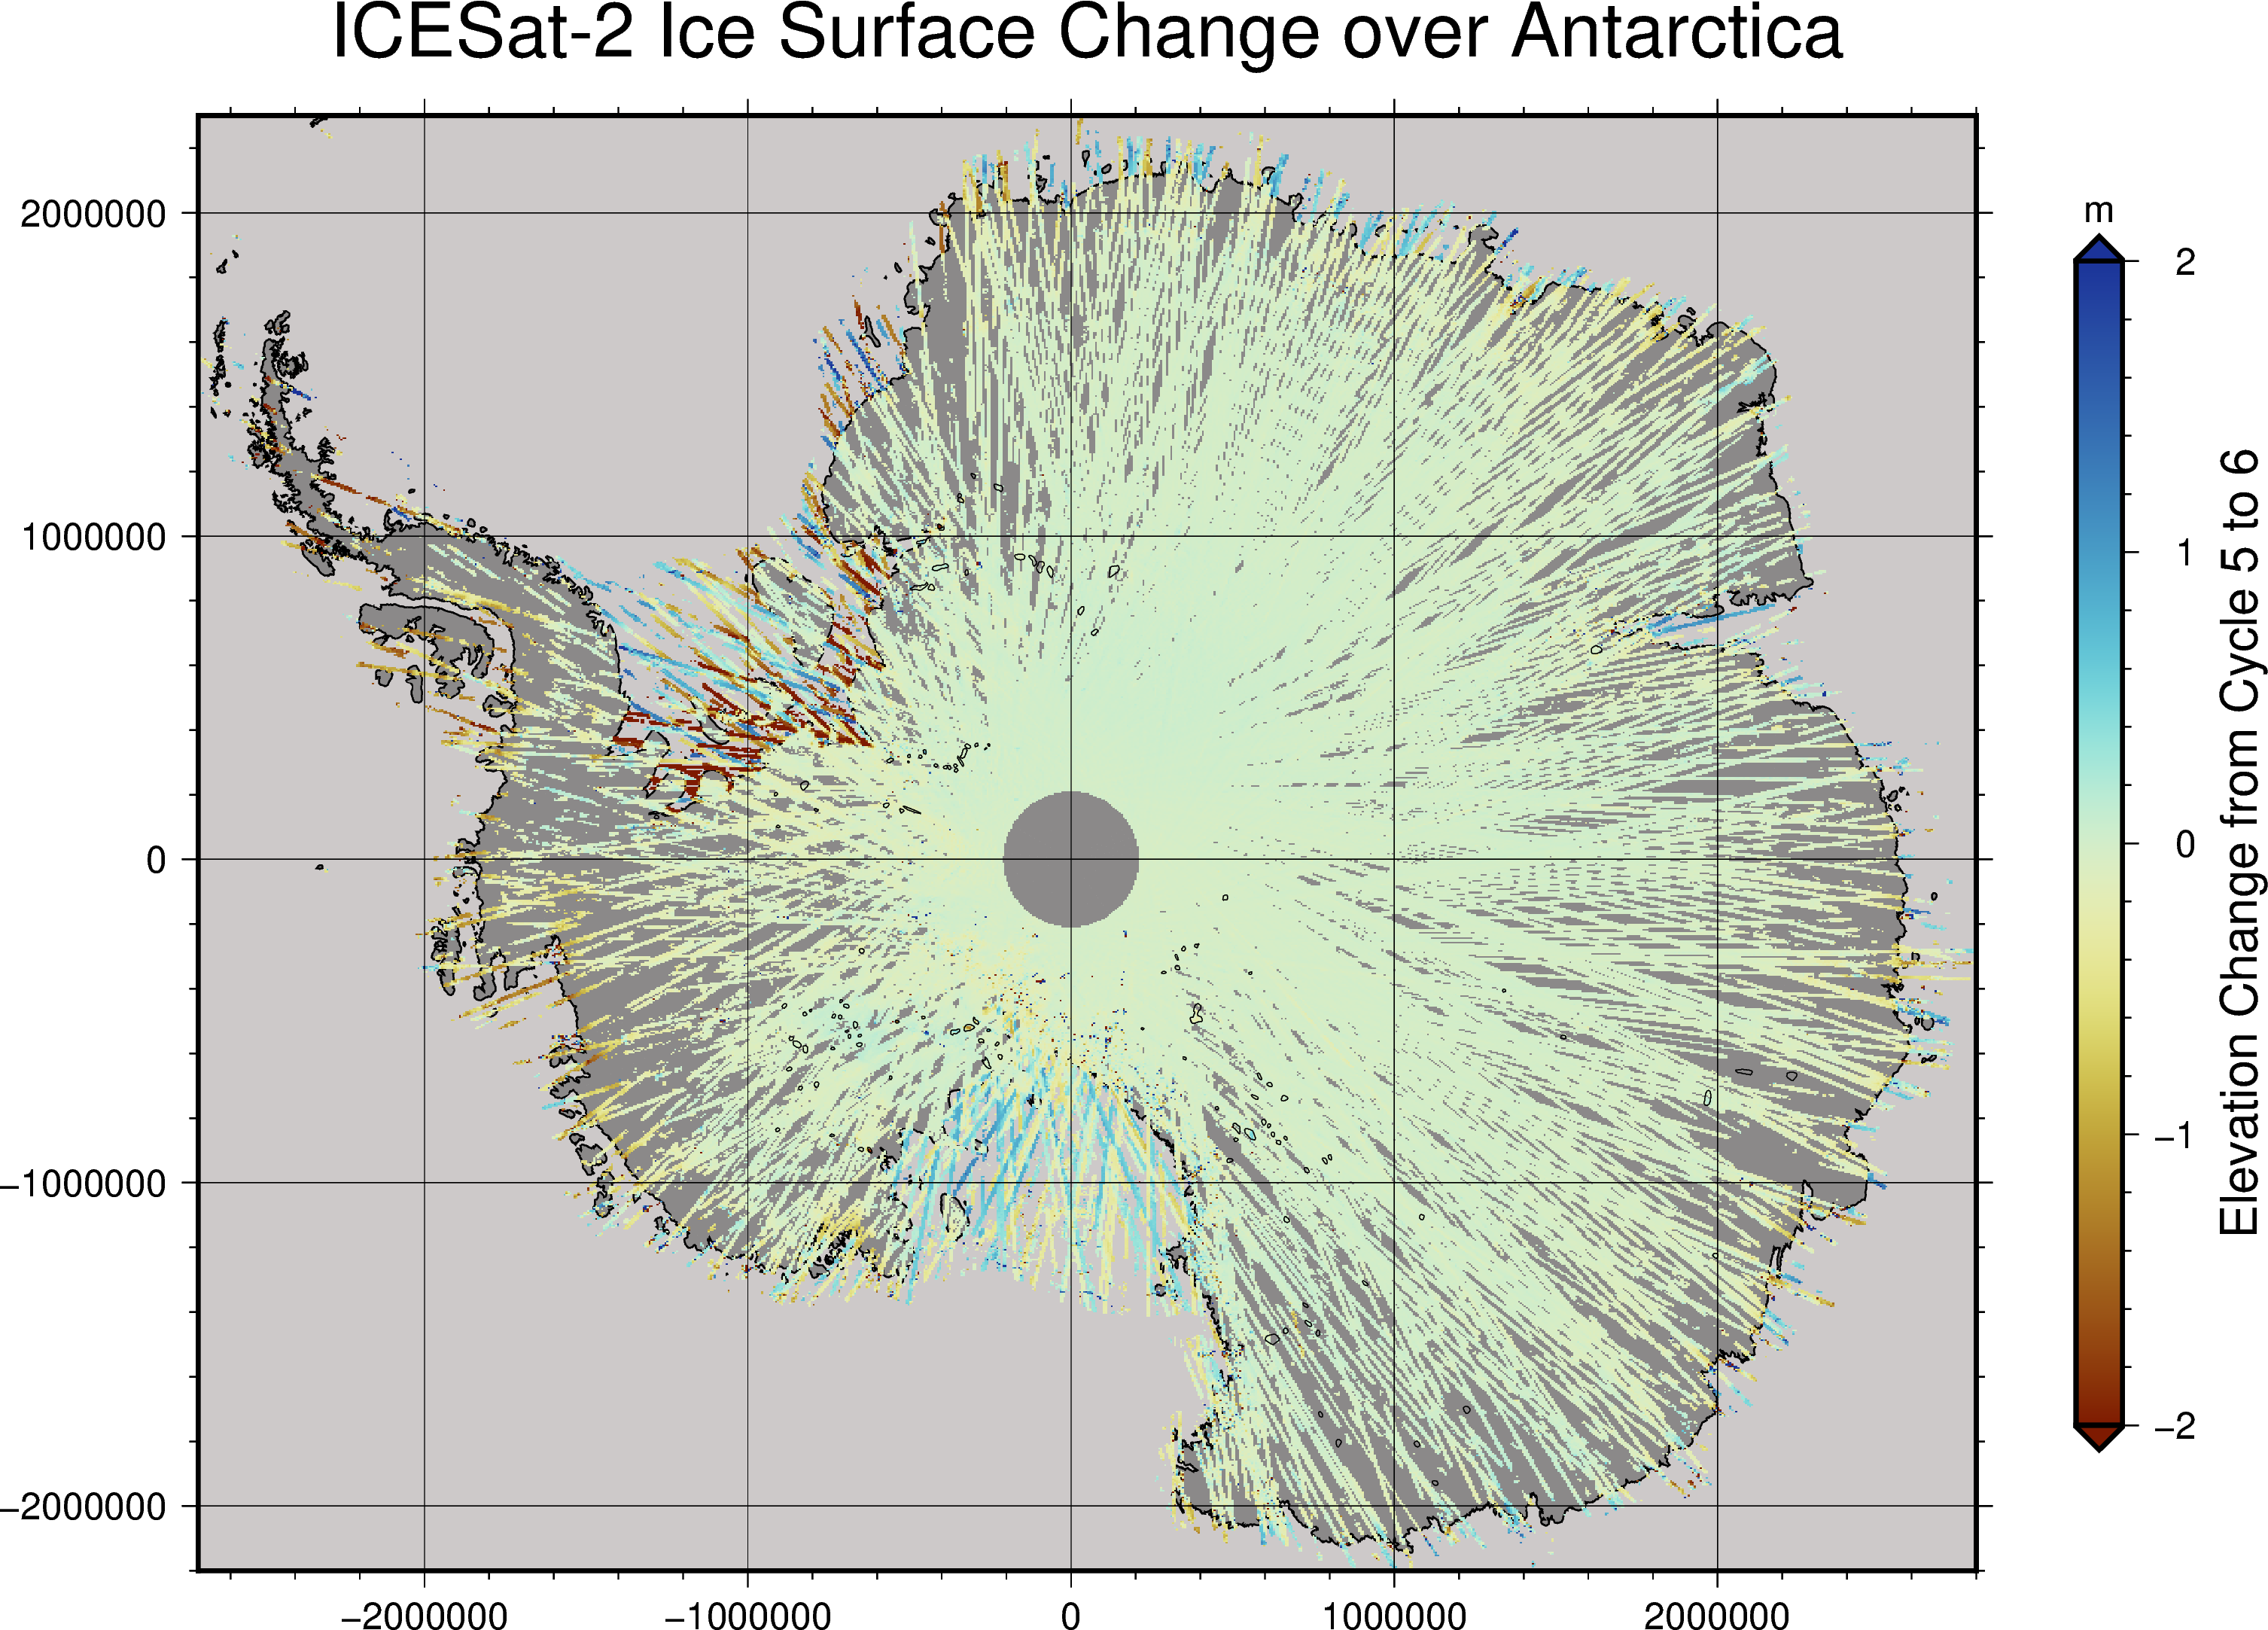

In [21]:
# Plot our map!
scale: int = region.scale
fig = pygmt.Figure()
fig.coast(
    region=region.bounds(),
    projection=f"s0/-90/-71/1:{scale}",
    area_thresh="+ag",
    resolution="i",
    shorelines="0.5p",
    land="snow4",
    water="snow3",
    V="q",
)
# fig.grdimage(
#    grid="Quantarctica3/SatelliteImagery/MODIS/MODIS_Mosaic.tif",
#    region=region,
#    projection=f"x{scale}",
#    I="+d",
# )
pygmt.makecpt(cmap="roma", series=[-2, 2])
fig.grdimage(
    grid=agg_grid,
    region=region.bounds(),
    projection=f"x1:{scale}",
    frame=["afg", f'WSne+t"ICESat-2 Ice Surface Change over {region.name}"',],
    Q=True,
)
for subglacial_lake in subglacial_lakes:
    fig.plot(data=subglacial_lake, L=True, pen="thinnest")
fig.colorbar(
    position="JCR+e", frame=["af", 'x+l"Elevation Change from Cycle 5 to 6"', "y+lm"],
)
fig.savefig(f"figures/plot_atl11_dh56_{placename}.png")
fig.show(width=600)

#### Non-PyGMT plotting code on PyViz stack

Meant to be a bit more interactive but slightly buggy,
need to sort out python dependency issues.

In [ ]:
import matplotlib.cm

In [ ]:
shade_grid = datashader.transfer_functions.shade(
    agg=agg_grid, cmap=matplotlib.cm.RdYlBu, how="linear", span=[-2, 2]
)
spread_grid = datashader.transfer_functions.dynspread(shade_grid)
spread_grid

In [ ]:
df_dh.hvplot.points(
    # title="Elevation Change (metres) from Cycle 5 to 6",
    x="x",
    y="y",
    c="delta_height",
    # cmap="RdYlBu",
    # aggregator=datashader.mean("delta_height"),
    rasterize=True,
    # responsive=True,
    # datashade=True,
    # dynamic=True,
    # dynspread=True,
    hover=True,
    height=400,
    symmetric=True,
    clim=(-20, 20),
)

In [ ]:
points = hv.Points(
    data=df_dh,
    kdims=["x", "y"],
    vdims=["delta_height"],
    # datatype=["xarray"],
)

In [ ]:
hv.operation.datashader.datashade(points)